In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import google.generativeai as genai
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
import os

load_dotenv()

genai.configure(api_key=os.getenv("GEMINI API KEY"))

transcripts = pd.read_csv("data/transcripts.csv")
transcripts.head()
transcripts.shape

(2467, 2)

["Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we've had and in all of the people here. Just the variety of it and the range of it. The second is that it's put us in a place where we have no idea what's going to", " happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don't you? I find this very interesting. If you're at a dinner party, and you say you work in education — Actually, you're not often at dinner parties, frankly.(Laughter)If you work in education, you're not asked.(Laughter)And you're never asked back, curiously. That's strange to me. But if you are, and you say to somebody, you know,",

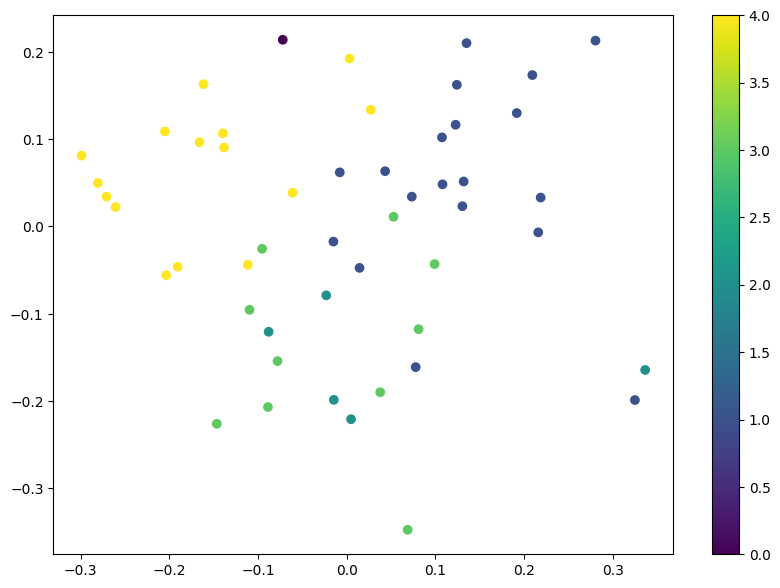

In [84]:
talking = transcripts.iloc[0:50]["transcript"]
model = SentenceTransformer('all-MiniLM-L6-v2') 
talking_list = talking.tolist()
def chunk_text(text, chunk_size):
    chunk_s = chunk_size
    curr_index = chunk_size
    last_index = 0
    chunks = []
    while len(text) > curr_index:
        while text[curr_index] != ' ' and curr_index > last_index:
            curr_index -= 1
        chunks.append(text[last_index:curr_index])
        last_index = curr_index
        curr_index += chunk_size
    return chunks
print(chunk_text(talking[0], 500))
embeddings = []
for talk in talking_list:
    chunks = chunk_text(talk, 500)
    chunk_embedding = []
    for chunk in chunks:
        response = model.encode(chunk)
        chunk_embedding.append(response)
    talk_embedding = np.mean(chunk_embedding, axis=0)
    embeddings.append(talk_embedding)
print(len(embeddings[0]))
print(len(embeddings))
embeddings = np.array(embeddings)
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(embeddings)
labels = kmeans.labels_
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')
plt.colorbar()

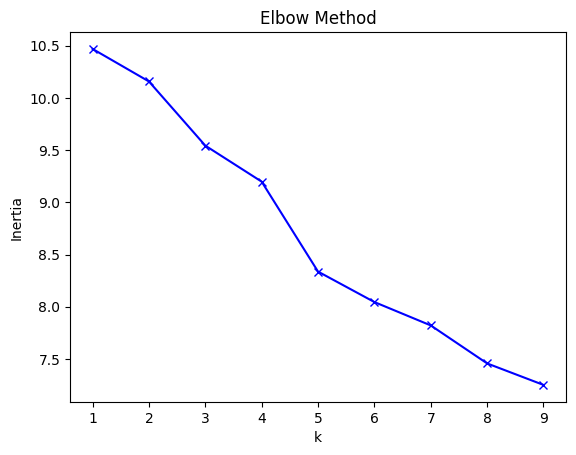

In [85]:
inertias = []
K = range(1, 10)  # test k from 1 to 9

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

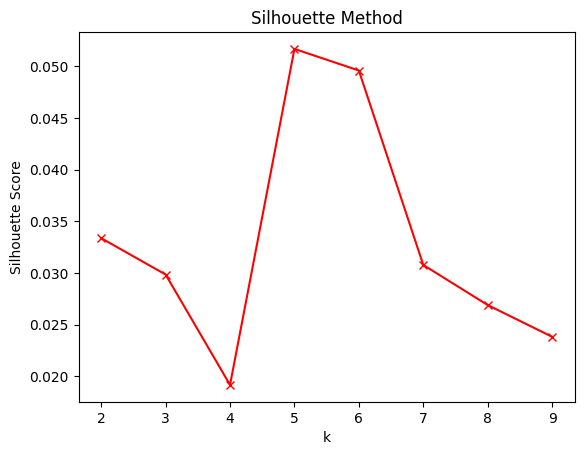

In [86]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 10), silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()
